In [1]:
using Gen
using Distributions
using Random
using Plots
using Genify

In [2]:
@gen function gbm_model(T::Int, S0::Float64, delta_t::Float64)
    # Latent parameters
    mu_var ~ normal(0.06, 0.01)  # drift
    sigma_var ~ normal(0.18, 0.05)  # volatility
    
    stock_prices = Float64[]
    S = S0
    
    for t in 1:T
        ε = @trace(normal(0.0, 1.0), (:epsilon, t))
        
        S = S * exp((mu_var - 0.5 * sigma_var^2) * delta_t + sigma_var * ε * sqrt(delta_t))
        
        # Observation with small noise
        obs = @trace(normal(S, 0.1), (:obs, t))
        push!(stock_prices, obs)
    end
    
    return stock_prices
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], Main.var"##gbm_model#277", Bool[0, 0, 0], false)

Observed stock prices (first 10):
[99.02494850435244, 98.6165708623339, 99.09988962510859, 98.05360801844479, 98.79566891963566, 101.02733835271911, 102.06715356431488, 101.60614452447987, 101.22747712754708, 101.87843175693091]

Latent parameters:
μ = 0.06177076707542234
σ = 0.23334216480083206


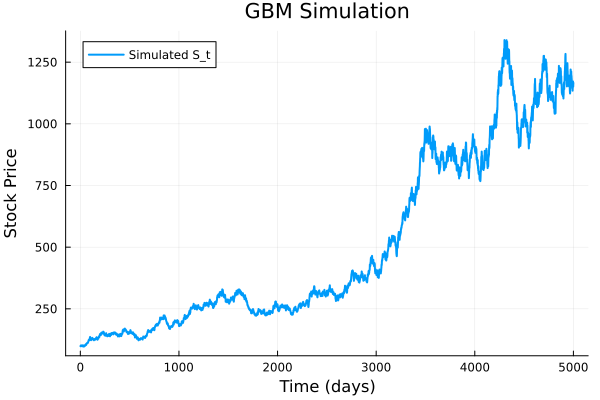

In [3]:
Random.seed!(61)
T = 5000
S0 = 100.0
delta_t = 1.0/365.0  # Daily time step

(trace, _) = generate(gbm_model, (T, S0, delta_t))
observations = get_retval(trace)

println("Observed stock prices (first 10):")
println(observations[1:10])

println("\nLatent parameters:")
println("μ = ", trace[:mu_var])
println("σ = ", trace[:sigma_var])

# Plot trajectory
using Plots
plot(1:T, observations, label="Simulated S_t", 
     xlabel="Time (days)", ylabel="Stock Price", 
     title="GBM Simulation", lw=2, legend=:topleft)

In [4]:
@gen function gbm_proposal(T::Int, S0::Float64, delta_t::Float64, prev_mu::Float64, prev_sigma::Float64)
    # Propose new parameters with small random walk steps
    mu_var ~ normal(prev_mu, 0.005)
    sigma_var ~ normal(prev_sigma, 0.01)
    
    stock_prices = Float64[]
    S = S0
    
    for t in 1:T
        ε = @trace(normal(0.0, 1.0), (:epsilon, t))
        S = S * exp((mu_var - 0.5 * sigma_var^2) * delta_t + sigma_var * ε * sqrt(delta_t))
        obs = @trace(normal(S, 0.1), (:obs, t))
        push!(stock_prices, obs)
    end
    
    return stock_prices
end

# Create initial trace with observed data
obs_constraints = choicemap()
for t in 1:T
    obs_constraints[(:obs, t)] = observations[t]
end
(current_trace, _) = generate(gbm_model, (T, S0, delta_t), obs_constraints)

# Metropolis-Hastings sampling
num_iterations = 1000
samples_mu = Float64[]
samples_sigma = Float64[]

accepted_num = 0

for i in 1:num_iterations
    # Propose new parameters via MH on the current trace
    param_sel = select(:mu_var, :sigma_var)
    (current_trace, accepted) = mh(current_trace, param_sel)

    if accepted
        accepted_num += 1
    end
    
    current_mu = current_trace[:mu_var]
    current_sigma = current_trace[:sigma_var]
    
    # Print the first proposal parameters
    if i == 1
        println("First proposal: μ = ", current_mu, ", σ = ", current_sigma, ", accepted = ", accepted)
    end
    
    push!(samples_mu, current_mu)
    push!(samples_sigma, current_sigma)
    
    if i % 100 == 0
        println("Iteration $i: μ = $current_mu, σ = $current_sigma")
    end
end

println("\nMean estimates:")
println("μ = ", mean(samples_mu[500:end]))
println("σ = ", mean(samples_sigma[500:end]))
println("Acceptance rate: ", accepted_num / num_iterations)

First proposal: μ = 0.06490902284541973, σ = 0.1887667478103478, accepted = false
Iteration 100: μ = 0.08088376873734408, σ = 0.14914937998410085
Iteration 200: μ = 0.093468195218774, σ = 0.13036372188981857
Iteration 300: μ = 0.093468195218774, σ = 0.13036372188981857
Iteration 400: μ = 0.093468195218774, σ = 0.13036372188981857
Iteration 500: μ = 0.093468195218774, σ = 0.13036372188981857
Iteration 600: μ = 0.093468195218774, σ = 0.13036372188981857
Iteration 700: μ = 0.093468195218774, σ = 0.13036372188981857
Iteration 800: μ = 0.093468195218774, σ = 0.13036372188981857
Iteration 900: μ = 0.093468195218774, σ = 0.13036372188981857
Iteration 1000: μ = 0.093468195218774, σ = 0.13036372188981857

Mean estimates:
μ = 0.09346819521877404
σ = 0.1303637218898186
Acceptance rate: 0.003



Initial HMC trace parameters:
μ = 0.093468195218774
σ = 0.13036372188981857
First HMC sample: μ = 0.093468195218774, σ = 0.13036372188981857, accepted = false
HMC Iteration 100: μ = 0.093468195218774, σ = 0.13036372188981857
HMC Iteration 200: μ = 0.093468195218774, σ = 0.13036372188981857
HMC Iteration 300: μ = 0.093468195218774, σ = 0.13036372188981857
HMC Iteration 400: μ = 0.093468195218774, σ = 0.13036372188981857

HMC Mean estimates:
μ = NaN
σ = NaN
Acceptance rate: 0.0


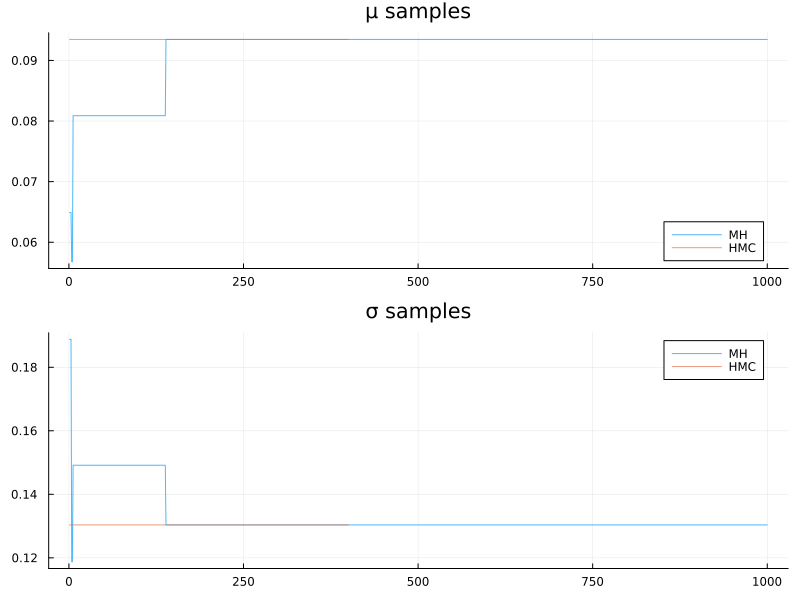

In [5]:
# HMC sampling for GBM parameters
num_hmc_iterations = 400
hmc_samples_mu = Float64[]
hmc_samples_sigma = Float64[]

# Initialize trace with observed data
hmc_trace = current_trace

# Print the current trace parameters
println("\nInitial HMC trace parameters:")
println("μ = ", hmc_trace[:mu_var])
println("σ = ", hmc_trace[:sigma_var])

accepted_num = 0

for i in 1:num_hmc_iterations
    # Apply HMC to sample mu_var and sigma_var
    (hmc_trace, accepted) = hmc(hmc_trace, select(:mu_var, :sigma_var), 
                                 eps=0.01, L=10, observations=obs_constraints)
    
    current_mu = hmc_trace[:mu_var]
    current_sigma = hmc_trace[:sigma_var]

    if accepted
        accepted_num += 1
    end
    
    if i == 1
        println("First HMC sample: μ = ", current_mu, ", σ = ", current_sigma, ", accepted = ", accepted)
    end
    
    push!(hmc_samples_mu, current_mu)
    push!(hmc_samples_sigma, current_sigma)
    
    if i % 100 == 0
        println("HMC Iteration $i: μ = $current_mu, σ = $current_sigma")
    end
end

println("\nHMC Mean estimates:")
println("μ = ", mean(hmc_samples_mu[500:end]))
println("σ = ", mean(hmc_samples_sigma[500:end]))
println("Acceptance rate: ", accepted_num / num_hmc_iterations)
# Plot comparison
p1 = plot(samples_mu, label="MH", alpha=0.7, title="μ samples")
plot!(hmc_samples_mu, label="HMC", alpha=0.7)

p2 = plot(samples_sigma, label="MH", alpha=0.7, title="σ samples")
plot!(hmc_samples_sigma, label="HMC", alpha=0.7)

plot(p1, p2, layout=(2,1), size=(800, 600))

In [6]:
# Importance sampling for GBM parameters
num_importance_samples = 1000
importance_weights = Float64[]
importance_samples_mu = Float64[]
importance_samples_sigma = Float64[]

for i in 1:num_importance_samples
    # Generate a trace from the prior (proposal distribution)
    (prop_trace, prop_weight) = generate(gbm_model, (T, S0, delta_t))
    
    # Update trace with observations
    (updated_trace, update_weight) = update(prop_trace, obs_constraints)
    
    # Calculate importance weight
    weight = update_weight
    
    push!(importance_weights, weight)
    push!(importance_samples_mu, updated_trace[:mu_var])
    push!(importance_samples_sigma, updated_trace[:sigma_var])
    
    if i % 100 == 0
        println("IS Iteration $i: μ = ", updated_trace[:mu_var], ", σ = ", updated_trace[:sigma_var])
    end
end

# Normalize weights
normalized_weights = exp.(importance_weights .- maximum(importance_weights))
normalized_weights ./= sum(normalized_weights)

# Compute weighted estimates
is_mu_estimate = sum(importance_samples_mu .* normalized_weights)
is_sigma_estimate = sum(importance_samples_sigma .* normalized_weights)

println("\nImportance Sampling estimates:")
println("μ = ", is_mu_estimate)
println("σ = ", is_sigma_estimate)
println("Effective sample size: ", 1.0 / sum(normalized_weights.^2))

IS Iteration 100: μ = 0.05636041940979093, σ = 0.15702882234528803
IS Iteration 200: μ = 0.06118276548254824, σ = 0.11226055503065376
IS Iteration 300: μ = 0.07634713615255842, σ = 0.12436537748233184
IS Iteration 400: μ = 0.056952654584458084, σ = 0.12856608480081452
IS Iteration 500: μ = 0.07651482745773844, σ = 0.1442003200781844
IS Iteration 600: μ = 0.05722052374266456, σ = 0.17246862056993734
IS Iteration 700: μ = 0.0426294647479345, σ = 0.27564555164574284
IS Iteration 800: μ = 0.046915530680777855, σ = 0.1266206429615936
IS Iteration 900: μ = 0.06701053802434272, σ = 0.2368201488306737
IS Iteration 1000: μ = 0.08017883460114689, σ = 0.19318313211761956

Importance Sampling estimates:
μ = 0.07344343842190808
σ = 0.16348879959422088
Effective sample size: 1.0


In [7]:
function log_likelihood(trace, y)
    x = get_retval(trace)  # Get the return value from the trace
    sum(Distributions.logpdf.(Normal(0, 1e-6), x .- y))
end

log_likelihood (generic function with 1 method)

In [8]:
# Custom algorithm:

function infer_gbm_params(
    y::Vector{Float64},
    delta_t::Float64,
    x0::Float64;
    n_iters::Int = 5000
)
    T = length(y)

    # Initial trace
    trace, _ = generate(gbm_model, (T, x0, delta_t), choicemap(:mu_var => 0.06, :sigma_var => 0.18))
    mu_var = trace[:mu_var]
    sigma_var = trace[:sigma_var]

    samples = Vector{Tuple{Float64, Float64}}()

    num_accepted = 0

    for iter in 1:n_iters
        mu_var_next = mu_var + 0.01 * randn()      # Smaller steps for better mixing
        sigma_var_next = sigma_var + 0.015 * randn()

        # Regenerate trace with proposed parameters
        trace_next, _ = generate(
            gbm_model,
            (T, x0, delta_t),
            choicemap(
                :mu_var => mu_var_next,
                :sigma_var => sigma_var_next
            )
        )

        # Compute log acceptance ratio
        logp =
            Distributions.logpdf(Normal(0.06, 0.01), mu_var_next) +
            Distributions.logpdf(Normal(0.18, 0.05), sigma_var_next)

        logp_old =
            Distributions.logpdf(Normal(0.06, 0.01), mu_var) +
            Distributions.logpdf(Normal(0.18, 0.05), sigma_var)

        ll_new = log_likelihood(trace_next, y)
        ll_old = log_likelihood(trace, y)

        logα = (logp + ll_new) - (logp_old + ll_old)

        if log(rand()) < logα
            mu_var, sigma_var = mu_var_next, sigma_var_next
            trace = trace_next

            num_accepted += 1

            println("Accepted new params at iteration $iter")
        end

        push!(samples, (mu_var, sigma_var))
        
        if iter % 2000 == 0 || iter <= 200
            println("Iteration $iter: mu = $mu_var, sigma = $sigma_var")
        end
    end
    println("Acceptance rate: ", num_accepted / n_iters)

    return samples
end


infer_gbm_params (generic function with 1 method)

In [9]:
# Run inference with more iterations
samples = infer_gbm_params(observations, delta_t, S0, n_iters=10000)

# Use only post-burn-in samples for estimates
burn_in = 1
mean_mu = mean(first.(samples[burn_in:end]))
mean_sigma = mean(last.(samples[burn_in:end]))

println("Estimated μ ≈ $mean_mu")
println("Estimated σ ≈ $mean_sigma")

Accepted new params at iteration 1
Iteration 1: mu = 0.05706043112215811, sigma = 0.21133379096056853
Accepted new params at iteration 2
Iteration 2: mu = 0.07669237528476688, sigma = 0.21097388432157999
Iteration 3: mu = 0.07669237528476688, sigma = 0.21097388432157999
Iteration 4: mu = 0.07669237528476688, sigma = 0.21097388432157999
Iteration 5: mu = 0.07669237528476688, sigma = 0.21097388432157999
Iteration 6: mu = 0.07669237528476688, sigma = 0.21097388432157999
Iteration 7: mu = 0.07669237528476688, sigma = 0.21097388432157999
Iteration 8: mu = 0.07669237528476688, sigma = 0.21097388432157999
Iteration 9: mu = 0.07669237528476688, sigma = 0.21097388432157999
Iteration 10: mu = 0.07669237528476688, sigma = 0.21097388432157999
Iteration 11: mu = 0.07669237528476688, sigma = 0.21097388432157999
Iteration 12: mu = 0.07669237528476688, sigma = 0.21097388432157999
Accepted new params at iteration 13
Iteration 13: mu = 0.09099785710107074, sigma = 0.20675826765049457
Iteration 14: mu = 